# Deep Learning & Art: Neural Style Transfer

主要参考论文： Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

Neural Style Transfer的主要思想：

1. 使用一个已经训练好的CNN（例如VGG-16），不再训练参数，而是训练一个输入的”图像“。
2. 目标损失函数包括两类： Content Loss 和 Style Loss
    1. Content Loss 的意思是原图片C与生成图片G，经过相同层后的输出，在内容上的差异（损失）。
    2. Style Loss 的意思是风格图片S与生成图片G，在经过相同层后的输出，在风格上的差异（损失）。这里定义风格为 channels之间的协方差矩阵。这样理解：协方差表示两个channel之间的相关性。A和B相关，表示出现A，也会出现B。一种风格可以用channels之间的协方差矩阵表示。 风格差异可以用协方差矩阵的距离（F范数）表示。
    3. 每一层上都可以给出一个 Content Loss和一个Style Loss，加权可以得到总Loss


非常简单的CNN，也能做很好的NST。 

硬要说问题， 就是这种风格定义是数字的，具有明确意义的，是理性的而非感性的。 但往往艺术作品，感性成分居多。每种风格都有不同的情感、线条、色彩等等。

这种作品可以量产，其艺术价值何在？ 我觉的NST最大的价值，在于证明： 

1. CNN的中间层确实学习到了图片的特征； 
2. 作品风格可以定义成channel之间的协方差矩阵。


In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



## 1. Model（VGG-19）

使用一个训练好的模型，19层。 不关心输出，只关心中间的 conv layer。


In [2]:
import scipy.io


def load_vgg_model(path):
    """
    parameters: conv: filters, W, b;   fc: W, b
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b
    
    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), 
                                   dtype = 'float32')
    
    # CONV1:  input: (, 300, 400, 3)
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')     # (, 300, 400, 64)
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')   # (, 300, 400, 64)
    graph['avgpool1'] = _avgpool(graph['conv1_2'])                     # (, 150, 200, 64)   f=2, s=2, padding='same'
    
    # CONV2:  
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')  # (, 150, 200, 128)
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')   # (, 150, 200, 128)
    graph['avgpool2'] = _avgpool(graph['conv2_2'])                     # (, 75, 100, 128)
    
    # CONV3:
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1') # (, 75, 100, 256)
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')  # (, 75, 100, 256)
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')  # (, 75, 100, 256)
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')  # (, 75, 100, 256)
    graph['avgpool3'] = _avgpool(graph['conv3_4'])                     # (, 38, 50, 256)   f=2, s=2, padding='same'
    
    # CONV4:
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1') # (, 38, 50, 512)
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')  # (, 38, 50, 512)
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')  # (, 38, 50, 512)
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')  # (, 38, 50, 512)
    graph['avgpool4'] = _avgpool(graph['conv4_4'])                     # (, 19, 25, 512)
    
    # CONV5: 
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1') # (, 19, 25, 512)
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')  # (, 19, 25, 512)
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')  # (, 19, 25, 512)
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')  # (, 19, 25, 512)
    graph['avgpool5'] = _avgpool(graph['conv5_4'])                     # (, 10, 13, 512)
    
    return graph



## 2. Input Image

需要三个图片：

- Content Image， 内容图片，待转换的图片
- Style Image， 风格图片， 比如莫奈、毕加索之类的风格图片
- 初始的Generated Image， 从Content Image 加一些噪声得到。


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


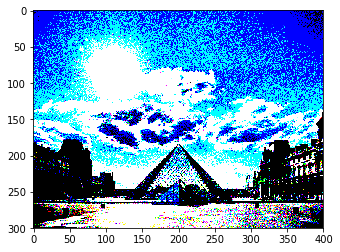

In [3]:
import imageio

class CONFIG:
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = 'pretrained-model/imagenet-vgg-verydeep-19.mat' # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = 'images/stone_style.jpg' # Style image to use.
    CONTENT_IMAGE = 'images/content300.jpg' # Content image to use.
    OUTPUT_DIR = 'output/'
    
# input images
def input_image(img_path):
    image = imageio.imread(img_path)
    image = np.reshape(image, ((1,) + image.shape))
    image = image - CONFIG.MEANS  # MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    return image

def generate_noise_image(content_image, noise_ratio = CONFIG.NOISE_RATIO):
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype('float32')
    # Set the input_image to be a weighted average of the content_image and a noise_image
    g = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return g

content_image = input_image("images/louvre_small.jpg")
style_image = input_image("images/monet.jpg")
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])


## 3. Cost Function

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### Content Cost

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

### Style Cost

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

### Total Cost

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [4]:

# load model
tf.reset_default_graph()
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")


def compute_content_cost(a_C, a_G):
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G 
    a_C_unrolled = tf.reshape(a_C, [m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, [m, -1, n_C])
    
    # compute the cost with tensorflow 
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C, a_G))) / 4 / n_H / n_W / n_C
    return J_content

def compute_layer_style_cost(a_S, a_G):
    # Retrieve dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_S = tf.transpose(tf.reshape(a_S, [-1, n_C]))  
    a_G = tf.transpose(tf.reshape(a_G, [-1, n_C]))  

    # Computing gram_matrices for both images S and G 
    GS = tf.matmul(a_S, tf.transpose(a_S))
    GG = tf.matmul(a_G, tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (2 * n_C * n_H * n_W) **2
    
    return J_style_layer


def nst_cost(sess, content_image, style_image, alpha=10, beta=40):
    # evaluate a_C for fixed content image
    sess.run(model['input'].assign(content_image))
    a_C = sess.run(model['conv4_2'])

    # a_G
    a_G = model['conv4_2']
    J_content = compute_content_cost(a_C, a_G)

    # evaluate a_S for 5 conv layers of fixed style image
    sess.run(model['input'].assign(style_image))

    STYLE_LAYERS = [
        ('conv1_1', 0.2),
        ('conv2_1', 0.2),
        ('conv3_1', 0.2),
        ('conv4_1', 0.2),
        ('conv5_1', 0.2)]

    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        # evaluate a_S for each layer
        a_S = sess.run(out)
        # a_G not evaluated 
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer
        
    J = alpha * J_content + beta * J_style
    return J_content, J_style, J



In [5]:
# interactive session
sess = tf.InteractiveSession()
J_content, J_style, J = nst_cost(sess, content_image, style_image)

# define optimizer
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)


## 4. Train Model For Neural Style Transfer


In [6]:
def save_image(path, image):
    image = image + CONFIG.MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    imageio.imsave(path, image)

def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_image))
             
    for i in range(num_iterations):
        sess.run(train_step)
        generated_image = sess.run(model['input'])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
#     return generated_image

In [7]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5053872600.0
content cost = 7861.588
style cost = 126344840.0
Iteration 20 :
total cost = 939505000.0
content cost = 15010.935
style cost = 23483874.0
Iteration 40 :
total cost = 482155460.0
content cost = 16606.703
style cost = 12049734.0
Iteration 60 :
total cost = 315689000.0
content cost = 17318.117
style cost = 7887895.0
Iteration 80 :
total cost = 230518510.0
content cost = 17700.53
style cost = 5758537.5
Iteration 100 :
total cost = 182589260.0
content cost = 17969.29
style cost = 4560239.0
Iteration 120 :
total cost = 151742380.0
content cost = 18166.4
style cost = 3789018.0
Iteration 140 :
total cost = 129598344.0
content cost = 18316.186
style cost = 3235379.5
Iteration 160 :
total cost = 112619120.0
content cost = 18420.56
style cost = 2810872.8
Iteration 180 :
total cost = 99267790.0
content cost = 18523.387
style cost = 2477064.0


可以观察到 content_cost会有一点增长（毕竟初始化的图片与原图片只有一点噪声差异）， 但是style_cost 在迅速减少。

输出记录了训练过程中，图片的变化。

## 5 - 合并一下

In [8]:

def neural_style_transfer(sess, content_img_path, style_img_path, num_iterations=200):
    # 3 images
    content_image = input_image(content_img_path)
    style_image = input_image(style_img_path)
    generated_image = generate_noise_image(content_image)
    
    # cost function
    J_content, J_style, J = nst_cost(sess, content_image, style_image)
    
    # optimizer
    optimizer = tf.train.AdamOptimizer(2.0).minimize(J)
    
    # train
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(generated_image))
    
    for i in range(num_iterations):
        sess.run(optimizer)
        _g_image = sess.run(model['input'])

        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", _g_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', _g_image)
    


In [9]:
neural_style_transfer(sess, "images/louvre_small.jpg", "images/sandstone.jpg")

Iteration 0 :
total cost = 14028438000.0
content cost = 7708.188
style cost = 350709020.0
Iteration 20 :
total cost = 4798144000.0
content cost = 17751.0
style cost = 119949160.0
Iteration 40 :
total cost = 2004258600.0
content cost = 20748.578
style cost = 50101276.0
Iteration 60 :
total cost = 837500800.0
content cost = 22219.248
style cost = 20931964.0
Iteration 80 :
total cost = 446390820.0
content cost = 22891.234
style cost = 11154047.0
Iteration 100 :
total cost = 294963400.0
content cost = 23329.543
style cost = 7368253.0
Iteration 120 :
total cost = 220258990.0
content cost = 23652.23
style cost = 5500561.5
Iteration 140 :
total cost = 174696960.0
content cost = 23904.37
style cost = 4361448.0
Iteration 160 :
total cost = 143598460.0
content cost = 24116.598
style cost = 3583932.5
Iteration 180 :
total cost = 120952970.0
content cost = 24305.85
style cost = 3017747.8



You can also tune your hyperparameters: 
- Which layers are responsible for representing the style? STYLE_LAYERS
- How many iterations do you want to run the algorithm? num_iterations
- What is the relative weighting between content and style? alpha/beta

## 6 - Conclusion

Great job on completing this assignment! You are now able to use Neural Style Transfer to generate artistic images. This is also your first time building a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. Deep learning has many different types of models and this is only one of them! 

<font color='blue'>
What you should remember:
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




This was the final programming exercise of this course. Congratulations--you've finished all the programming exercises of this course on Convolutional Networks! We hope to also see you in Course 5, on Sequence models! 


### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
